# Analysis of AI Incident Database

### Load files

In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import numpy as np

# Set your data directory
data_dir = '/Users/luciadelatorre/Desktop/COLUMBIA/MASTERSTHESIS/mongodump_full_snapshot'

# List of main CSV files to load
csv_files = [
    'incidents.csv',
    'reports.csv',
    'submissions.csv',
    'duplicates.csv',
    'quickadd.csv',
    'classifications_CSETv0.csv',
    'classifications_CSETv1_Annotator-1.csv',
    'classifications_CSETv1_Annotator-2.csv',
    'classifications_CSETv1_Annotator-3.csv',
    'classifications_GMF.csv',
    'classifications_MIT.csv'
]

# Load each CSV into a dictionary of DataFrames
dfs = {}
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    if os.path.exists(file_path):
        dfs[file.replace('.csv', '')] = pd.read_csv(file_path)
    else:
        print(f"File not found: {file}")

# Example: Access the main incidents DataFrame
incidents_df = dfs['incidents']

# Preview the first few rows
print(incidents_df.head())

# List all loaded DataFrames
print("Loaded DataFrames:", list(dfs.keys()))


                                  _id  incident_id        date  \
0  ObjectId(625763db343edc875fe639ff)            1  2015-05-19   
1  ObjectId(625763de343edc875fe63a15)           23  2017-11-08   
2  ObjectId(625763dc343edc875fe63a02)            4  2018-03-18   
3  ObjectId(625763dd343edc875fe63a0a)           12  2016-07-21   
4  ObjectId(625763dc343edc875fe63a03)            5  2015-07-13   

                                             reports  \
0                 [1,2,3,4,5,6,7,8,9,10,11,12,14,15]   
1  [242,243,244,245,246,247,248,249,250,253,254,2...   
2  [629,630,631,632,633,634,635,636,637,638,639,6...   
3                                               [42]   
4  [767,768,769,770,771,772,773,774,775,776,777,778]   

                Alleged deployer of AI system  \
0                                 ["youtube"]   
1            ["navya","keolis-north-america"]   
2                                    ["uber"]   
3  ["microsoft-research","boston-university"]   
4                    

### 1. Temporal analysis: when were most incidents logged?

In [2]:
# Convert 'date' to datetime
incidents_df['date'] = pd.to_datetime(incidents_df['date'], errors='coerce')

# Extract year and month
incidents_df['year'] = incidents_df['date'].dt.year
incidents_df['month'] = incidents_df['date'].dt.to_period('M')

# Incidents per year
incidents_by_year = incidents_df['year'].value_counts().sort_index()
print("Incidents by year:\n", incidents_by_year)

# Incidents per month (optional, for finer granularity)
incidents_by_month = incidents_df['month'].value_counts().sort_index()
print("Incidents by month:\n", incidents_by_month)

Incidents by year:
 year
1983      1
1992      1
1996      1
1998      1
1999      1
2003      4
2006      1
2007      1
2008      3
2009      2
2010      1
2011      3
2012      8
2013      6
2014     13
2015     24
2016     41
2017     50
2018     45
2019     43
2020     87
2021     77
2022    103
2023    161
2024    265
2025    167
Name: count, dtype: int64
Incidents by month:
 month
1983-09     1
1992-05     1
1996-04     1
1998-03     1
1999-03     1
           ..
2025-02    39
2025-03    36
2025-04    32
2025-05    22
2025-06    13
Freq: M, Name: count, Length: 160, dtype: int64


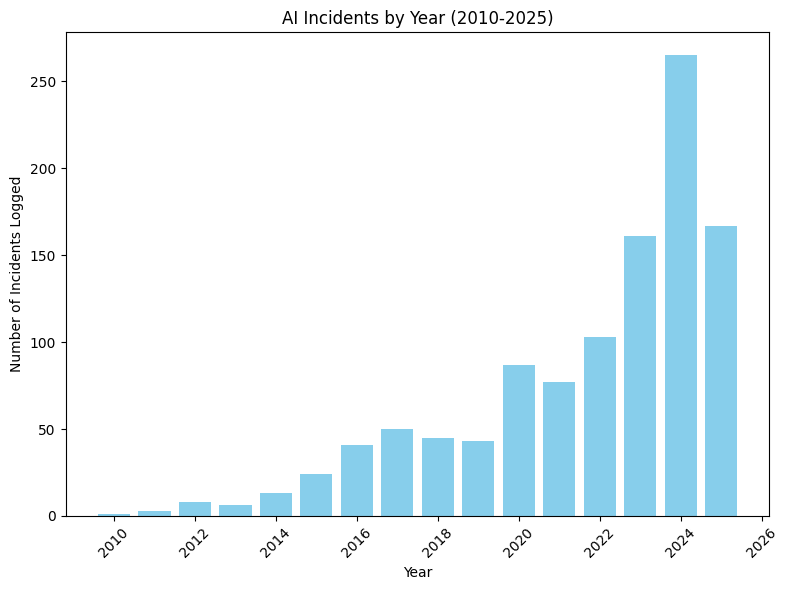

In [3]:
# Your data
incidents_by_year = {
    1983: 1, 1992: 1, 1996: 1, 1998: 1, 1999: 1, 2003: 4, 2006: 1, 2007: 1, 2008: 3, 2009: 2,
    2010: 1, 2011: 3, 2012: 8, 2013: 6, 2014: 13, 2015: 24, 2016: 41, 2017: 50, 2018: 45,
    2019: 43, 2020: 87, 2021: 77, 2022: 103, 2023: 161, 2024: 265, 2025: 167
}

# Convert to DataFrame
df = pd.DataFrame(list(incidents_by_year.items()), columns=['Year', 'Incidents'])
df_filtered = df[(df['Year'] >= 2010) & (df['Year'] <= 2025)]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(df_filtered['Year'], df_filtered['Incidents'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Incidents Logged')
plt.title('AI Incidents by Year (2010-2025)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2. Geographical analysis

In [4]:
# Load the classifications_CSETv0.csv file
cset_path = os.path.join(data_dir, 'classifications_CSETv0.csv')
classifications_csetv0 = pd.read_csv(cset_path)

# Preview the first few rows and columns
print(classifications_csetv0.head())
print(classifications_csetv0.columns.tolist())

  Namespace  Incident ID  Published  Annotator      Annotation Status  \
0    CSETv0            5       True          2  6. Complete and final   
1    CSETv0            3      False          1  6. Complete and final   
2    CSETv0           48       True          4  6. Complete and final   
3    CSETv0           77       True          5  6. Complete and final   
4    CSETv0           67       True          6  6. Complete and final   

   Reviewer Quality Control  \
0         2           False   
1         6           False   
2         6           False   
3         2           False   
4         2           False   

                                    Full Description  \
0  Reports of robotic surgeries resulting in inju...   
1  A Boeing 737 MAX aircraft equipped with a new,...   
2  Richard Lee, a New Zealander of Asian descent ...   
3  A Knightscope K5 autonomous security robot was...   
4  A Tesla Model S continued autopilot at 70 mph ...   

                                   Sh

In [5]:
import ast

classifications_csetv0['Beginning Date'] = pd.to_datetime(classifications_csetv0['Beginning Date'], errors='coerce')

def safe_literal_eval(val):
    try:
        if pd.isna(val) or val == '':
            return []
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [val] if pd.notnull(val) else []

classifications_csetv0['Location'] = classifications_csetv0['Location'].apply(safe_literal_eval)

# Filter for incidents from 2010 onwards
filtered_df = classifications_csetv0[classifications_csetv0['Beginning Date'].dt.year >= 2010]

# Flatten the Location lists and count
all_locations = filtered_df['Location'].explode()
location_counts = all_locations.value_counts()

# Get the top 50 locations
top_50_locations = location_counts.head(50)
print(top_50_locations)


Location
Global                                                13
Palo Alto, CA                                          2
United States                                          2
Hamburg, Germany                                       1
Lagos, Nigeria                                         1
Jokkmokk, Sweden                                       1
United Kingdom                                         1
Robbinsville, New Jersey, United States of America     1
Los Angeles, CA                                        1
UK/USA                                                 1
Delhi, India                                           1
Las Vegas, NV                                          1
Storey County, Nevada                                  1
New York, NY                                           1
Baunatal, Germany                                      1
Ireland                                                1
Inverness, Scotland, UK                                1
USA                   

In [6]:
# Consolidating data
def extract_country(location):
    if not isinstance(location, str):
        return None
    location = location.lower()
    if 'united states' in location or 'usa' in location:
        return 'United States'
    if 'germany' in location:
        return 'Germany'
    if 'india' in location:
        return 'India'
    if 'nigeria' in location:
        return 'Nigeria'
    if 'sweden' in location:
        return 'Sweden'
    if 'global' in location:
        return 'Global'
    if 'uk' in location or 'united kingdom' in location:
        return 'United Kingdom'
    # Add more rules as needed
    # Fallback: take last word if it looks like a country
    parts = location.split(',')
    if parts:
        return parts[-1].strip().title()
    return location.title()

# Apply to flattened locations
country_counts = all_locations.dropna().apply(extract_country).value_counts()
print(country_counts.head(20))

Location
Global            13
United States      5
Ca                 3
United Kingdom     2
India              2
Germany            2
Sweden             1
Nigeria            1
Nevada             1
Nv                 1
Ny                 1
Ireland            1
Florida            1
Fl                 1
Name: count, dtype: int64


In [10]:
def extract_country(location):
    if not isinstance(location, str):
        return None
    location = location.strip()
    # Handle 'Global' or empty
    if location.lower() == 'global':
        return 'Global'
    # If there's a comma, take the last part as country
    if ',' in location:
        return location.split(',')[-1].strip().title()
    # If it's just a country, return as title-case
    return location.title()
def clean_country_mapping(location):
    if not isinstance(location, str):
        return None
    location = location.lower()

    # Consolidate US states under 'United States'
    us_states = ['united states', 'usa', 'ca', 'california', 'nevada', 'nv', 'ny', 'new york', 'florida', 'fl']
    if any(state in location for state in us_states):
        return 'United States'

    if 'united kingdom' in location or 'uk' in location:
        return 'United Kingdom'
    if 'germany' in location:
        return 'Germany'
    if 'india' in location:
        return 'India'
    # Add more countries as needed

    return location.title()
# Apply extract_country first to strip city names
cleaned_countries = all_locations.dropna().apply(extract_country)
# Then apply clean_country_mapping to consolidate US states
final_countries = cleaned_countries.apply(clean_country_mapping)
# Count occurrences
final_counts = final_countries.value_counts()
print(final_counts)
final_counts.to_frame('Incident_Count').to_csv('ai_incidents_by_country.csv')

Location
United States     15
Global            13
United Kingdom     2
India              2
Nigeria            1
Sweden             1
Ireland            1
Name: count, dtype: int64


In [14]:
# Create a proper DataFrame for QGIS
country_data = pd.DataFrame({
    'Country': final_counts.index,
    'Incident_Count': final_counts.values
})

# Save for QGIS
country_data.to_csv('ai_incidents_for_qgis.csv', index=False)

In [19]:
import pandas as pd
import ast
import numpy as np

# Assuming your data is already loaded as classifications_csetv0
# If not, uncomment the following lines:
# data_dir = '/Users/luciadelatorre/Desktop/COLUMBIA/MASTERSTHESIS/mongodump_full_snapshot'
# cset_path = os.path.join(data_dir, 'classifications_CSETv0.csv')
# classifications_csetv0 = pd.read_csv(cset_path)

# Function to safely parse location data
def safe_literal_eval(val):
    try:
        if pd.isna(val) or val == '' or (isinstance(val, np.ndarray) and val.size == 0):
            return []
        if isinstance(val, list):
            return val
        if isinstance(val, str):
            if val.startswith('[') and val.endswith(']'):
                return ast.literal_eval(val)
            else:
                return [val]
        return [str(val)] if val is not None else []
    except (ValueError, SyntaxError):
        return [str(val)] if pd.notnull(val) else []

# Parse locations and dates
classifications_csetv0['Location_parsed'] = classifications_csetv0['Location'].apply(safe_literal_eval)
classifications_csetv0['Beginning Date'] = pd.to_datetime(classifications_csetv0['Beginning Date'], errors='coerce')

# Filter for incidents from 2010 onwards
filtered_df = classifications_csetv0[classifications_csetv0['Beginning Date'].dt.year >= 2010]

# US states mapping
us_states_map = {
    'alabama': 'Alabama', 'al': 'Alabama',
    'alaska': 'Alaska', 'ak': 'Alaska',
    'arizona': 'Arizona', 'az': 'Arizona',
    'arkansas': 'Arkansas', 'ar': 'Arkansas',
    'california': 'California', 'ca': 'California',
    'colorado': 'Colorado', 'co': 'Colorado',
    'connecticut': 'Connecticut', 'ct': 'Connecticut',
    'delaware': 'Delaware', 'de': 'Delaware',
    'district of columbia': 'District of Columbia', 'dc': 'District of Columbia',
    'florida': 'Florida', 'fl': 'Florida',
    'georgia': 'Georgia', 'ga': 'Georgia',
    'hawaii': 'Hawaii', 'hi': 'Hawaii',
    'idaho': 'Idaho', 'id': 'Idaho',
    'illinois': 'Illinois', 'il': 'Illinois',
    'indiana': 'Indiana', 'in': 'Indiana',
    'iowa': 'Iowa', 'ia': 'Iowa',
    'kansas': 'Kansas', 'ks': 'Kansas',
    'kentucky': 'Kentucky', 'ky': 'Kentucky',
    'louisiana': 'Louisiana', 'la': 'Louisiana',
    'maine': 'Maine', 'me': 'Maine',
    'maryland': 'Maryland', 'md': 'Maryland',
    'massachusetts': 'Massachusetts', 'ma': 'Massachusetts',
    'michigan': 'Michigan', 'mi': 'Michigan',
    'minnesota': 'Minnesota', 'mn': 'Minnesota',
    'mississippi': 'Mississippi', 'ms': 'Mississippi',
    'missouri': 'Missouri', 'mo': 'Missouri',
    'montana': 'Montana', 'mt': 'Montana',
    'nebraska': 'Nebraska', 'ne': 'Nebraska',
    'nevada': 'Nevada', 'nv': 'Nevada',
    'new hampshire': 'New Hampshire', 'nh': 'New Hampshire',
    'new jersey': 'New Jersey', 'nj': 'New Jersey',
    'new mexico': 'New Mexico', 'nm': 'New Mexico',
    'new york': 'New York', 'ny': 'New York',
    'north carolina': 'North Carolina', 'nc': 'North Carolina',
    'north dakota': 'North Dakota', 'nd': 'North Dakota',
    'ohio': 'Ohio', 'oh': 'Ohio',
    'oklahoma': 'Oklahoma', 'ok': 'Oklahoma',
    'oregon': 'Oregon', 'or': 'Oregon',
    'pennsylvania': 'Pennsylvania', 'pa': 'Pennsylvania',
    'rhode island': 'Rhode Island', 'ri': 'Rhode Island',
    'south carolina': 'South Carolina', 'sc': 'South Carolina',
    'south dakota': 'South Dakota', 'sd': 'South Dakota',
    'tennessee': 'Tennessee', 'tn': 'Tennessee',
    'texas': 'Texas', 'tx': 'Texas',
    'utah': 'Utah', 'ut': 'Utah',
    'vermont': 'Vermont', 'vt': 'Vermont',
    'virginia': 'Virginia', 'va': 'Virginia',
    'washington': 'Washington', 'wa': 'Washington',
    'west virginia': 'West Virginia', 'wv': 'West Virginia',
    'wisconsin': 'Wisconsin', 'wi': 'Wisconsin',
    'wyoming': 'Wyoming', 'wy': 'Wyoming'
}

# Function to extract US state from location
def extract_us_state(location):
    if not isinstance(location, str):
        return None
    
    location_lower = location.lower().strip()
    
    # Direct state matches
    if location_lower in us_states_map:
        return us_states_map[location_lower]
    
    # Check if it contains US indicators
    us_indicators = ['united states', 'usa', 'us,', ', us', 'america']
    is_us_location = any(indicator in location_lower for indicator in us_indicators)
    
    # Split by comma and check each part
    parts = [p.strip().lower() for p in location.split(',')]
    
    # Search from rightmost part to leftmost
    for part in reversed(parts):
        part = part.strip()
        if part in us_states_map:
            return us_states_map[part]
    
    # Check for partial matches if it looks like a US location
    if is_us_location or any(state in location_lower for state in us_states_map.keys()):
        for state_key, state_name in us_states_map.items():
            if state_key in location_lower:
                return state_name
    
    return None

# Extract US state incidents
us_state_incidents = {}
us_general_incidents = 0  # Count for general "United States" entries

for idx, row in filtered_df.iterrows():
    locations = row['Location_parsed']
    if locations:
        for location in locations:
            if isinstance(location, str):
                location_lower = location.lower().strip()
                
                # Check for general US entries
                if location_lower in ['united states', 'usa', 'us']:
                    us_general_incidents += 1
                else:
                    # Try to extract specific state
                    state = extract_us_state(location)
                    if state:
                        us_state_incidents[state] = us_state_incidents.get(state, 0) + 1

# Sort by incident count (descending)
us_state_counts = dict(sorted(us_state_incidents.items(), key=lambda x: x[1], reverse=True))

# Add general US incidents if any
if us_general_incidents > 0:
    us_state_counts['United States (General)'] = us_general_incidents

# Print the results
print("AI Incidents by US State (2010-2025)")
print("=" * 40)
for state, count in us_state_counts.items():
    print(f"{state}: {count}")

total_us_incidents = sum(us_state_counts.values())
print(f"\nTotal US incidents: {total_us_incidents}")
print(f"  - Specific states: {sum(us_state_incidents.values())}")
print(f"  - General 'United States': {us_general_incidents}")

# Create a simple list/dictionary for easy use
us_incidents_list = us_state_counts
print(f"\nStates/categories with AI incidents: {len(us_incidents_list)}")

# You can also create a pandas Series for easier manipulation
us_incidents_series = pd.Series(us_state_counts, name='AI_Incidents')
us_incidents_series.index.name = 'State'

print("\nAs a pandas Series:")
print(us_incidents_series)

# Show breakdown
print(f"\n=== BREAKDOWN ===")
print(f"Your global analysis found 15 'United States' incidents")
print(f"This state-specific analysis found {sum(us_state_incidents.values())} incidents in specific states")
print(f"Plus {us_general_incidents} general US incidents")
print(f"Total should be: {sum(us_state_incidents.values()) + us_general_incidents}")

# Let's also check what those "United States" entries look like
print(f"\n=== CHECKING 'UNITED STATES' ENTRIES ===")
us_entries = []
for idx, row in filtered_df.iterrows():
    locations = row['Location_parsed']
    if locations:
        for location in locations:
            if isinstance(location, str) and location.lower().strip() in ['united states', 'usa', 'us']:
                us_entries.append(location)

print(f"Found {len(us_entries)} general US entries:")
for entry in set(us_entries):
    print(f"  - '{entry}': {us_entries.count(entry)} times")

# Save to CSV if needed
# us_incidents_series.to_csv('us_ai_incidents_by_state.csv', header=True)

AI Incidents by US State (2010-2025)
Alabama: 14
California: 3
Delaware: 2
Nevada: 2
Florida: 2
Iowa: 1
Massachusetts: 1
Indiana: 1
New Jersey: 1
New York: 1
Colorado: 1
Louisiana: 1
Arkansas: 1
United States (General): 3

Total US incidents: 34
  - Specific states: 31
  - General 'United States': 3

States/categories with AI incidents: 14

As a pandas Series:
State
Alabama                    14
California                  3
Delaware                    2
Nevada                      2
Florida                     2
Iowa                        1
Massachusetts               1
Indiana                     1
New Jersey                  1
New York                    1
Colorado                    1
Louisiana                   1
Arkansas                    1
United States (General)     3
Name: AI_Incidents, dtype: int64

=== BREAKDOWN ===
Your global analysis found 15 'United States' incidents
This state-specific analysis found 31 incidents in specific states
Plus 3 general US incidents
Total sh

/var/folders/31/rr3vvs0x69v0hzh5y29651200000gn/T/ipykernel_10360/223970373.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.isna(val) or val == '' or (isinstance(val, np.ndarray) and val.size == 0):


### 3. Sectoral analysis

Sector of Deployment
Information and communication                        26
Transportation and storage                           13
Arts, entertainment and recreation                   13
Public administration and defence                    12
Administrative and support service activities         7
Human health and social work activities               6
Education                                             6
Financial and insurance activities                    3
Professional, scientific and technical activities     3
Wholesale and retail trade                            2
Accommodation and food service activities             1
Activities of households as employers                 1
Name: count, dtype: int64


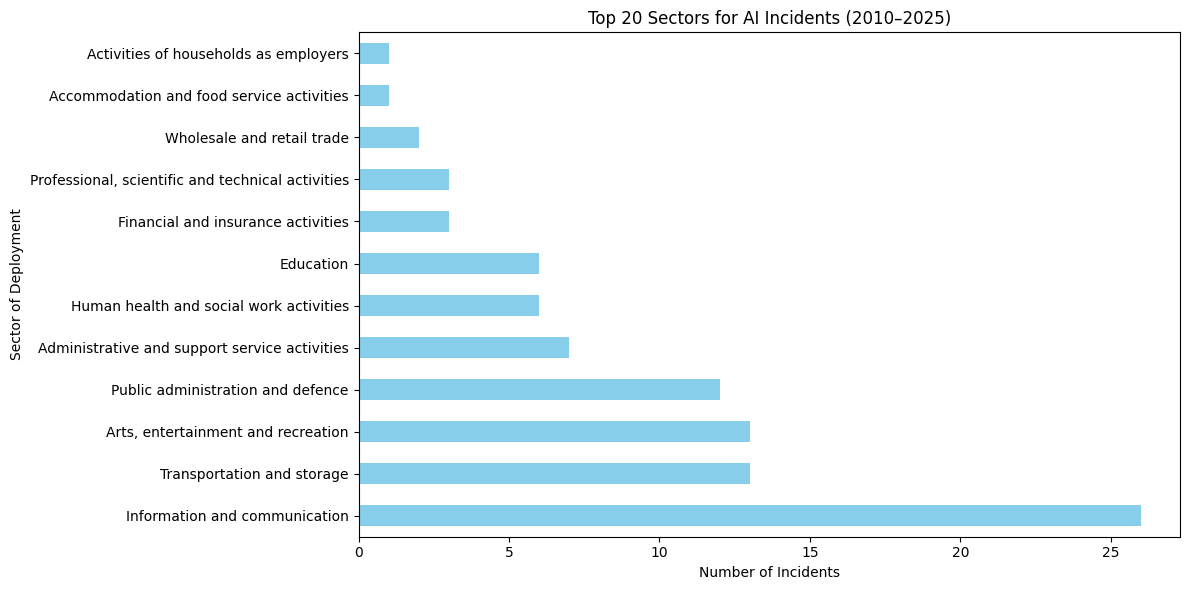

Sector of Deployment
Information and communication                        26
Transportation and storage                           13
Arts, entertainment and recreation                   13
Public administration and defence                    12
Administrative and support service activities         7
Human health and social work activities               6
Education                                             6
Financial and insurance activities                    3
Professional, scientific and technical activities     3
Wholesale and retail trade                            2
Accommodation and food service activities             1
Activities of households as employers                 1
Name: count, dtype: int64


In [12]:
# Count incidents by sector
sector_counts = classifications_csetv0['Sector of Deployment'].value_counts()

# Print the top 20 sectors
print(sector_counts.head(20))

# Plot the top 20 sectors
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sector_counts.head(20).plot(kind='barh', color='skyblue')
plt.xlabel('Number of Incidents')
plt.title('Top 20 Sectors for AI Incidents (2010–2025)')
plt.tight_layout()
plt.show()
print(sector_counts.head(20))
sector_counts.to_csv('ai_incidents_by_sector.csv', header=['Incident_Count'])